In [60]:

# Walmart Sales Forecasting Project
# Data Science Analysis for Weekly Sales Prediction

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

In [61]:
# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [62]:
file_path = "./Walmart.csv"

In [63]:
df = pd.read_csv(file_path)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [65]:
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [66]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [67]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

## Data Cleaning

In [68]:
# Function to parse different date formats
def parse_date(date_str):
    try:
        # Try DD/MM/YYYY format first
        if '/' in date_str:
            return pd.to_datetime(date_str, format='%d/%m/%Y')
        # Try DD-MM-YYYY format
        elif '-' in date_str:
            return pd.to_datetime(date_str, format='%d-%m-%Y')
        else:
            return pd.to_datetime(date_str)
    except:
        return pd.NaT

df['Date'] = df['Date'].apply(parse_date)
df = df.dropna(subset=['Date'])

In [69]:
# Extract date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Quarter'] = df['Date'].dt.quarter

# Create season feature
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['Season'] = df['Month'].apply(get_season)

In [70]:
# Encode categorical variables
le_season = LabelEncoder()
df['Season_Encoded'] = le_season.fit_transform(df['Season'])

print(f"Date features created successfully!")
print(f"Dataset shape after preprocessing: {df.shape}")


Date features created successfully!
Dataset shape after preprocessing: (6435, 15)


## EXPLORATORY DATA ANALYSIS

In [71]:
# Set up the plotting
fig = plt.figure(figsize=(40, 15))

<Figure size 4000x1500 with 0 Axes>

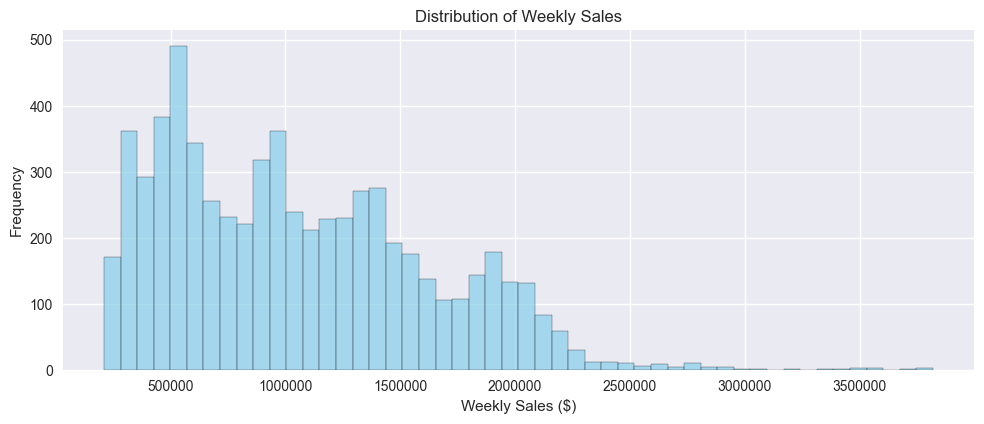

In [72]:

fig = plt.figure(figsize=(40, 15))
# 1. Distribution of Weekly Sales
plt.subplot(3, 3, 1)
plt.hist(df['Weekly_Sales'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Weekly Sales')
plt.xlabel('Weekly Sales ($)')
plt.ylabel('Frequency')
plt.ticklabel_format(style='plain', axis='x')


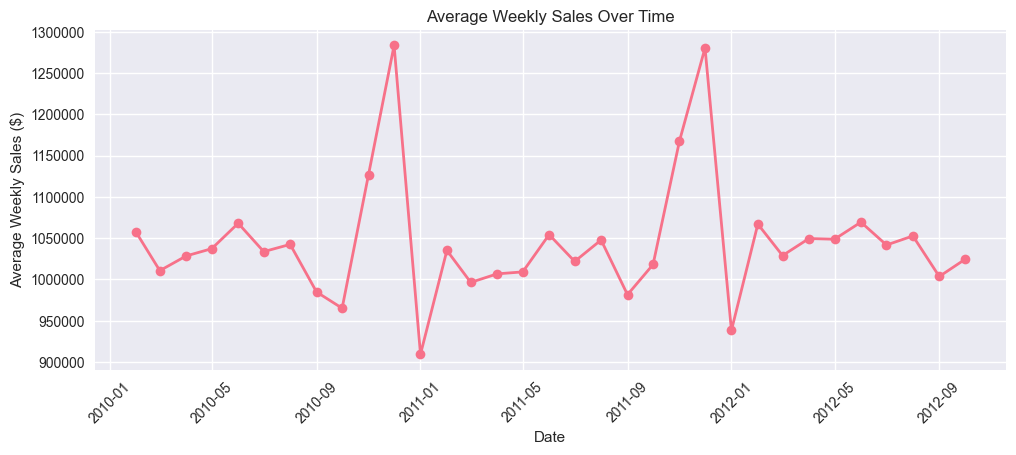

In [73]:
#Sales trends over time
fig = plt.figure(figsize=(40, 15))
plt.subplot(3, 3, 2)
monthly_sales = df.groupby(['Year', 'Month'])['Weekly_Sales'].mean().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(day=1))
plt.plot(monthly_sales['Date'], monthly_sales['Weekly_Sales'], marker='o', linewidth=2)
plt.title('Average Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Weekly Sales ($)')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')

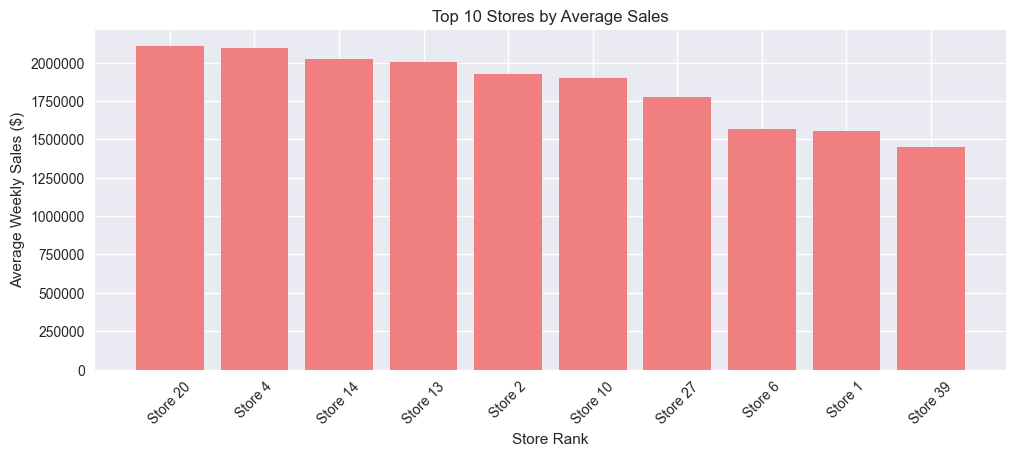

In [74]:
fig = plt.figure(figsize=(40, 15))
plt.subplot(3, 3, 3)
store_avg_sales = df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).head(10)
plt.bar(range(len(store_avg_sales)), store_avg_sales.values, color='lightcoral')
plt.title('Top 10 Stores by Average Sales')
plt.xlabel('Store Rank')
plt.ylabel('Average Weekly Sales ($)')
plt.xticks(range(len(store_avg_sales)), [f'Store {s}' for s in store_avg_sales.index], rotation=45)
plt.ticklabel_format(style='plain', axis='y')

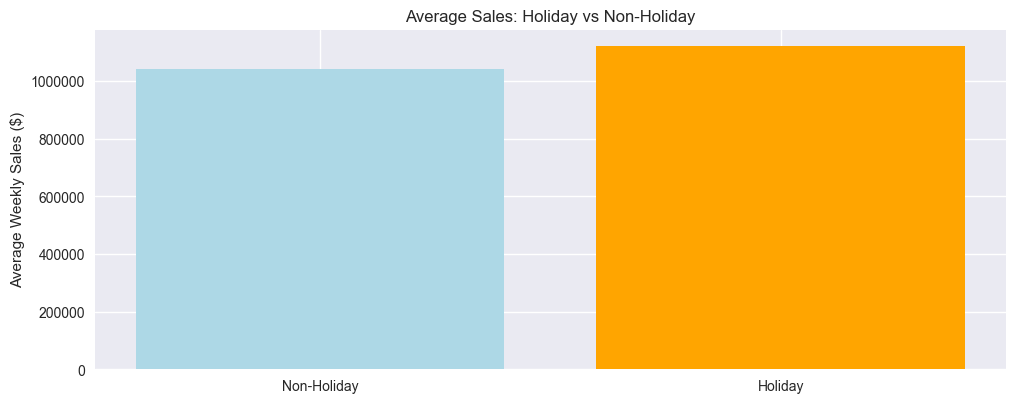

In [75]:
# 4. Holiday vs Non-Holiday Sales
fig = plt.figure(figsize=(40, 15))
plt.subplot(3, 3, 4)
holiday_sales = df.groupby('Holiday_Flag')['Weekly_Sales'].mean()
plt.bar(['Non-Holiday', 'Holiday'], holiday_sales.values, color=['lightblue', 'orange'])
plt.title('Average Sales: Holiday vs Non-Holiday')
plt.ylabel('Average Weekly Sales ($)')
plt.ticklabel_format(style='plain', axis='y')

In [76]:
# Add value labels on bars
#for i, v in enumerate(holiday_sales.values):
   # plt.text(i, v + 10000, f'${v:,.0f}', ha='center', va='bottom')

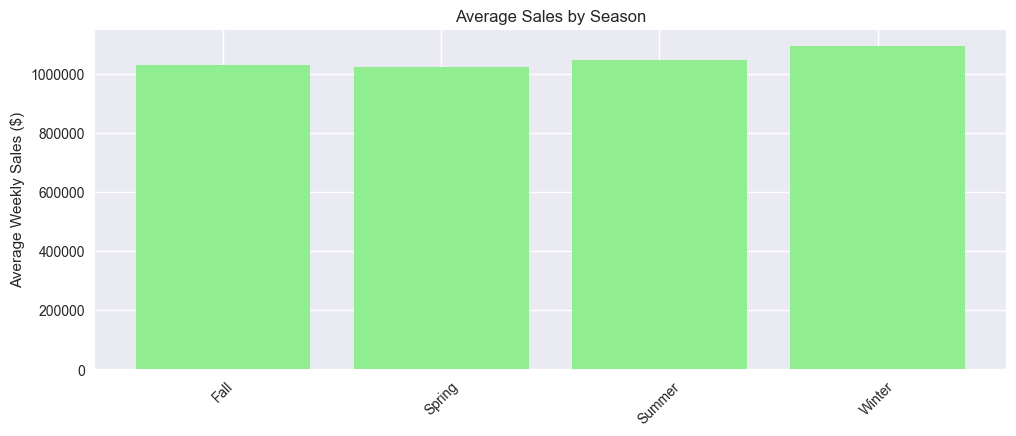

In [77]:
# 5. Seasonal Sales Pattern
fig = plt.figure(figsize=(40, 15))
plt.subplot(3, 3, 5)
seasonal_sales = df.groupby('Season')['Weekly_Sales'].mean()
plt.bar(seasonal_sales.index, seasonal_sales.values, color='lightgreen')
plt.title('Average Sales by Season')
plt.ylabel('Average Weekly Sales ($)')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')

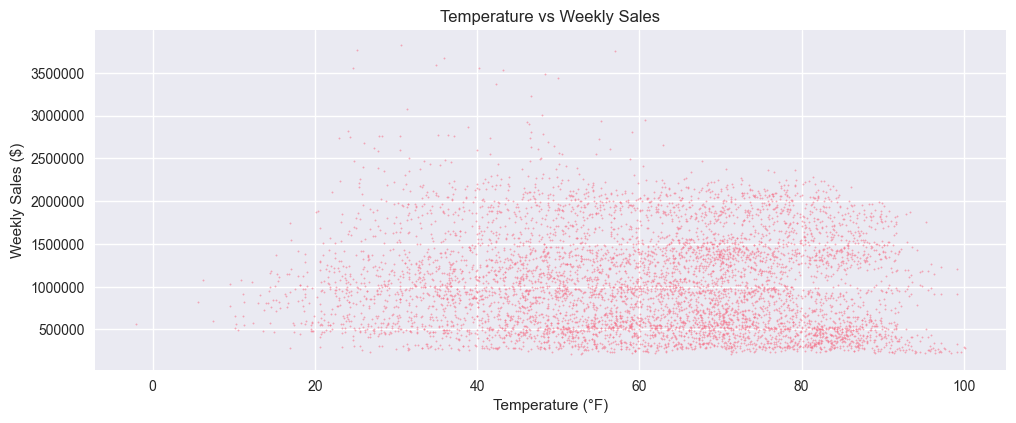

In [78]:
# 6. Temperature vs Sales
fig = plt.figure(figsize=(40, 15))
plt.subplot(3, 3, 6)
plt.scatter(df['Temperature'], df['Weekly_Sales'], alpha=0.5, s=1)
plt.title('Temperature vs Weekly Sales')
plt.xlabel('Temperature (°F)')
plt.ylabel('Weekly Sales ($)')
plt.ticklabel_format(style='plain', axis='y')

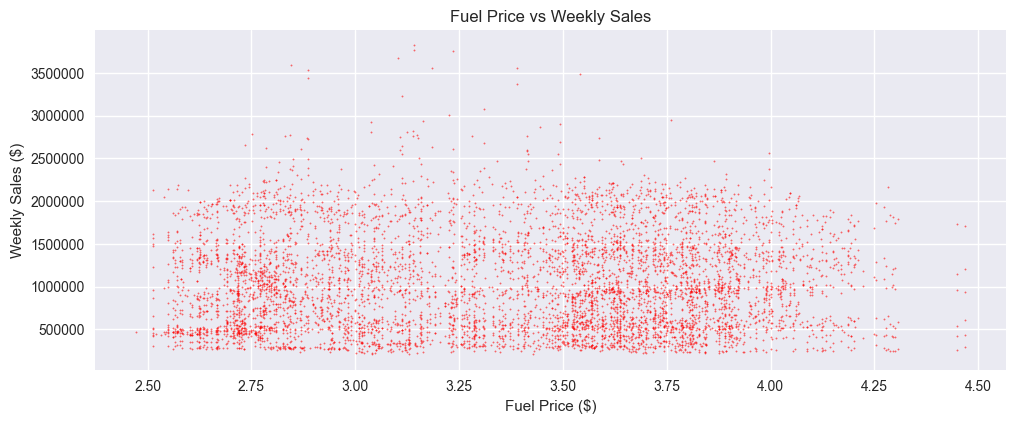

In [79]:
# 7. Fuel Price vs Sales
fig = plt.figure(figsize=(40, 15))
plt.subplot(3, 3, 7)
plt.scatter(df['Fuel_Price'], df['Weekly_Sales'], alpha=0.5, s=1, color='red')
plt.title('Fuel Price vs Weekly Sales')
plt.xlabel('Fuel Price ($)')
plt.ylabel('Weekly Sales ($)')
plt.ticklabel_format(style='plain', axis='y')

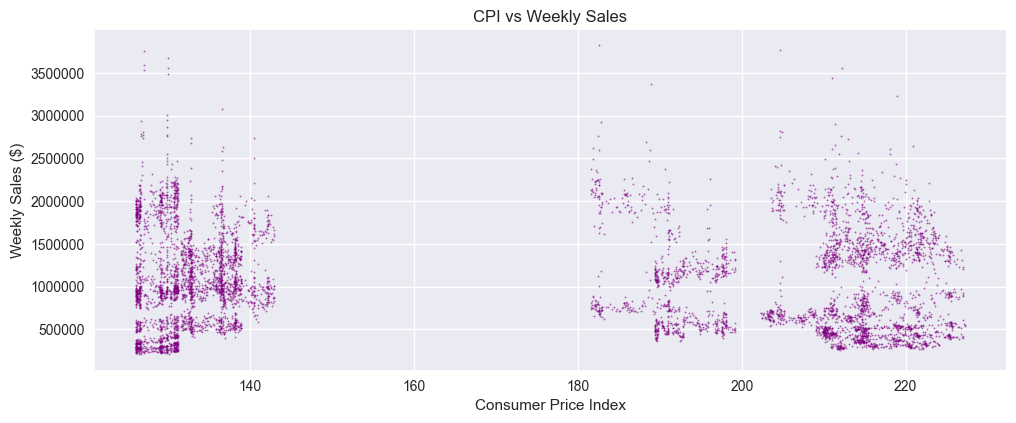

In [80]:
# 8. CPI vs Sales
fig = plt.figure(figsize=(40, 15))
plt.subplot(3, 3, 8)
plt.scatter(df['CPI'], df['Weekly_Sales'], alpha=0.5, s=1, color='purple')
plt.title('CPI vs Weekly Sales')
plt.xlabel('Consumer Price Index')
plt.ylabel('Weekly Sales ($)')
plt.ticklabel_format(style='plain', axis='y')

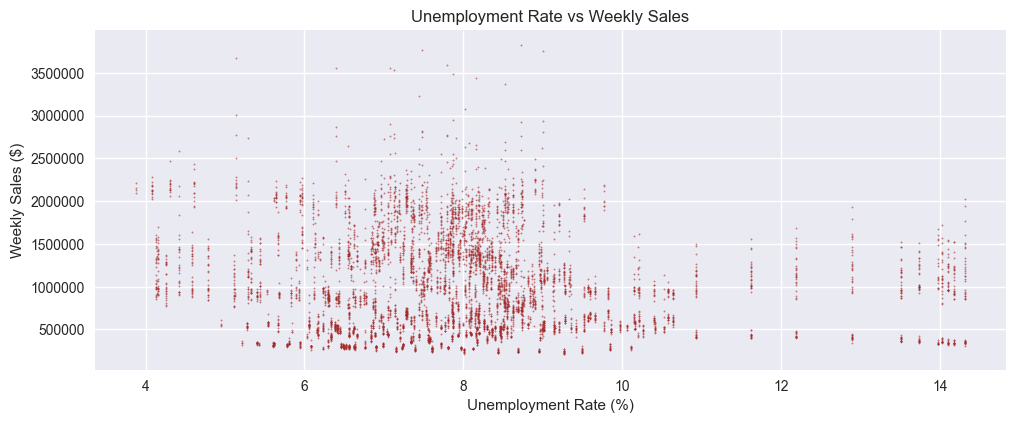

In [81]:
# 9. Unemployment vs Sales
fig = plt.figure(figsize=(40, 15))
plt.subplot(3, 3, 9)
plt.scatter(df['Unemployment'], df['Weekly_Sales'], alpha=0.5, s=1, color='brown')
plt.title('Unemployment Rate vs Weekly Sales')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Weekly Sales ($)')
plt.ticklabel_format(style='plain', axis='y')


Correlation Analysis:


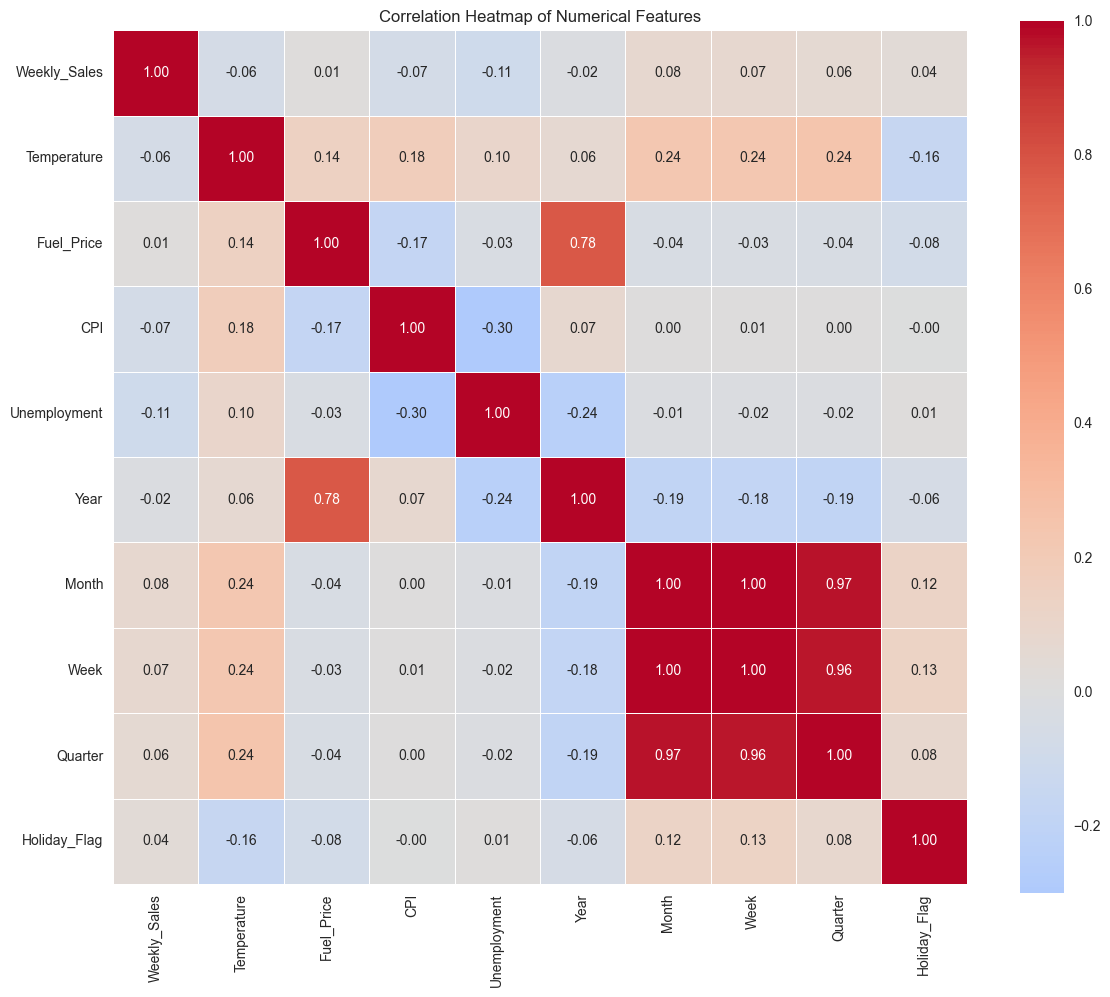

In [82]:
print("\nCorrelation Analysis:")
numerical_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                     'Year', 'Month', 'Week', 'Quarter', 'Holiday_Flag']
correlation_matrix = df[numerical_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

In [83]:
# Statistical insights
print(f"\nKEY INSIGHTS FROM EDA:")
print(f"- Average Weekly Sales: ${df['Weekly_Sales'].mean():,.2f}")
print(f"- Median Weekly Sales: ${df['Weekly_Sales'].median():,.2f}")
print(f"- Sales Standard Deviation: ${df['Weekly_Sales'].std():,.2f}")

holiday_avg = df[df['Holiday_Flag'] == 1]['Weekly_Sales'].mean()
non_holiday_avg = df[df['Holiday_Flag'] == 0]['Weekly_Sales'].mean()
print(f"- Holiday Sales Average: ${holiday_avg:,.2f}")
print(f"- Non-Holiday Sales Average: ${non_holiday_avg:,.2f}")
print(f"- Holiday Sales Lift: {((holiday_avg - non_holiday_avg) / non_holiday_avg * 100):,.1f}%")



KEY INSIGHTS FROM EDA:
- Average Weekly Sales: $1,046,964.88
- Median Weekly Sales: $960,746.04
- Sales Standard Deviation: $564,366.62
- Holiday Sales Average: $1,122,887.89
- Non-Holiday Sales Average: $1,041,256.38
- Holiday Sales Lift: 7.8%


In [84]:
# Top correlations with Weekly_Sales
sales_corr = correlation_matrix['Weekly_Sales'].abs().sort_values(ascending=False)
print(f"\nTop correlations with Weekly Sales:")
for feature, corr in sales_corr.head(6).items():
    if feature != 'Weekly_Sales':
        print(f"- {feature}: {corr:.3f}")


Top correlations with Weekly Sales:
- Unemployment: 0.106
- Month: 0.076
- Week: 0.074
- CPI: 0.073
- Temperature: 0.064


## Feature Engineering

In [85]:

print("\n3. FEATURE ENGINEERING")
print("-" * 40)

# Create lag features
print("Creating lag features...")
df_sorted = df.sort_values(['Store', 'Date'])

# Create lag features for Weekly_Sales (previous week, 2 weeks ago, etc.)
df_sorted['Sales_Lag1'] = df_sorted.groupby('Store')['Weekly_Sales'].shift(1)
df_sorted['Sales_Lag2'] = df_sorted.groupby('Store')['Weekly_Sales'].shift(2)
df_sorted['Sales_Lag4'] = df_sorted.groupby('Store')['Weekly_Sales'].shift(4)

# Create rolling averages
df_sorted['Sales_Rolling_4w'] = df_sorted.groupby('Store')['Weekly_Sales'].rolling(window=4, min_periods=1).mean().reset_index(0, drop=True)
df_sorted['Sales_Rolling_8w'] = df_sorted.groupby('Store')['Weekly_Sales'].rolling(window=8, min_periods=1).mean().reset_index(0, drop=True)

# Create binary indicators for economic conditions
df_sorted['High_Unemployment'] = (df_sorted['Unemployment'] > df_sorted['Unemployment'].median()).astype(int)
df_sorted['High_Fuel_Price'] = (df_sorted['Fuel_Price'] > df_sorted['Fuel_Price'].median()).astype(int)
df_sorted['High_CPI'] = (df_sorted['CPI'] > df_sorted['CPI'].median()).astype(int)

# Create interaction features
df_sorted['Holiday_Temperature'] = df_sorted['Holiday_Flag'] * df_sorted['Temperature']
df_sorted['Holiday_Unemployment'] = df_sorted['Holiday_Flag'] * df_sorted['Unemployment']

# Create store performance categories
store_performance = df_sorted.groupby('Store')['Weekly_Sales'].mean()
store_perf_quartiles = pd.qcut(store_performance, 4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
store_perf_map = store_perf_quartiles.to_dict()
df_sorted['Store_Performance'] = df_sorted['Store'].map(store_perf_map)

# Encode store performance
le_store_perf = LabelEncoder()
df_sorted['Store_Performance_Encoded'] = le_store_perf.fit_transform(df_sorted['Store_Performance'])

# Drop rows with NaN values created by lag features (keep most data)
df_final = df_sorted.dropna(subset=['Sales_Lag1']).copy()

print(f"Feature engineering completed!")
print(f"Final dataset shape: {df_final.shape}")
print(f"New features created: {len([col for col in df_final.columns if col not in df.columns])}")


3. FEATURE ENGINEERING
----------------------------------------
Creating lag features...
Feature engineering completed!
Final dataset shape: (6390, 27)
New features created: 12


In [86]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6390 entries, 1 to 6434
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      6390 non-null   int64         
 1   Date                       6390 non-null   datetime64[ns]
 2   Weekly_Sales               6390 non-null   float64       
 3   Holiday_Flag               6390 non-null   int64         
 4   Temperature                6390 non-null   float64       
 5   Fuel_Price                 6390 non-null   float64       
 6   CPI                        6390 non-null   float64       
 7   Unemployment               6390 non-null   float64       
 8   Year                       6390 non-null   int32         
 9   Month                      6390 non-null   int32         
 10  Week                       6390 non-null   UInt32        
 11  DayOfYear                  6390 non-null   int32         
 12  Quarter    

## Train test Split

In [103]:
# Select features for modeling
feature_columns = [
    'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'Year', 'Month', 'Week', 'Quarter', 'Season_Encoded',
    'Sales_Lag1','Sales_Rolling_4w', 'Sales_Rolling_8w',
    'High_Unemployment', 'High_Fuel_Price', 'High_CPI',
    'Holiday_Temperature', 'Holiday_Unemployment',
    'Store_Performance_Encoded'
]


In [105]:
print("\n4. MODEL PREPARATION")
print("-" * 40)


X = df_final[feature_columns].copy()
y = df_final['Weekly_Sales'].copy()

print(f"Features selected: {len(feature_columns)}")
print(f"Target variable: Weekly_Sales")
print(f"Training samples: {len(X)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                    stratify=df_final['Holiday_Flag'])

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Scale features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Also get holiday weights for evaluation (holidays are weighted 5x)
train_holiday_weights = np.where(df_final.loc[X_train.index, 'Holiday_Flag'] == 1, 5, 1)
test_holiday_weights = np.where(df_final.loc[X_test.index, 'Holiday_Flag'] == 1, 5, 1)

print("Data preparation completed!")



4. MODEL PREPARATION
----------------------------------------
Features selected: 20
Target variable: Weekly_Sales
Training samples: 6390
Training set size: (5112, 20)
Test set size: (1278, 20)
Data preparation completed!


In [107]:
df_final.isnull().sum()

Store                          0
Date                           0
Weekly_Sales                   0
Holiday_Flag                   0
Temperature                    0
Fuel_Price                     0
CPI                            0
Unemployment                   0
Year                           0
Month                          0
Week                           0
DayOfYear                      0
Quarter                        0
Season                         0
Season_Encoded                 0
Sales_Lag1                     0
Sales_Lag2                    45
Sales_Lag4                   135
Sales_Rolling_4w               0
Sales_Rolling_8w               0
High_Unemployment              0
High_Fuel_Price                0
High_CPI                       0
Holiday_Temperature            0
Holiday_Unemployment           0
Store_Performance              0
Store_Performance_Encoded      0
dtype: int64

## Linear Regression

In [108]:
# Scale features for linear regression
scaler_lr = StandardScaler()
X_train_scaled = scaler_lr.fit_transform(X_train)
X_test_scaled = scaler_lr.transform(X_test)

In [109]:
# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [110]:
# Make predictions
lr_train_pred = lr_model.predict(X_train_scaled)
lr_test_pred = lr_model.predict(X_test_scaled)

In [112]:
# Calculate metrics
lr_train_r2 = r2_score(y_train, lr_train_pred)
lr_test_r2 = r2_score(y_test, lr_test_pred)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, lr_train_pred))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, lr_test_pred))
lr_train_mae = mean_absolute_error(y_train, lr_train_pred)
lr_test_mae = mean_absolute_error(y_test, lr_test_pred)

# Weighted metrics (holiday emphasis)
lr_weighted_train_rmse = np.sqrt(np.average((y_train - lr_train_pred)**2, weights=train_holiday_weights))
lr_weighted_test_rmse = np.sqrt(np.average((y_test - lr_test_pred)**2, weights=test_holiday_weights))

# Cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')

print("LINEAR REGRESSION RESULTS:")
print(f"  Training R²: {lr_train_r2:.4f}")
print(f"  Test R²: {lr_test_r2:.4f}")
print(f"  Training RMSE: ${lr_train_rmse:,.2f}")
print(f"  Test RMSE: ${lr_test_rmse:,.2f}")
print(f"  Training MAE: ${lr_train_mae:,.2f}")
print(f"  Test MAE: ${lr_test_mae:,.2f}")
print(f"  Weighted Test RMSE (Holiday Focus): ${lr_weighted_test_rmse:,.2f}")
print(f"  Cross-Validation R² (mean ± std): {lr_cv_scores.mean():.4f} ± {lr_cv_scores.std():.4f}")

LINEAR REGRESSION RESULTS:
  Training R²: 0.9578
  Test R²: 0.9559
  Training RMSE: $116,131.37
  Test RMSE: $117,049.64
  Training MAE: $63,480.16
  Test MAE: $64,622.34
  Weighted Test RMSE (Holiday Focus): $154,272.10
  Cross-Validation R² (mean ± std): 0.9566 ± 0.0053


In [113]:
# Feature coefficients (top 10)
feature_coef = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_
})
feature_coef['Abs_Coefficient'] = abs(feature_coef['Coefficient'])
top_coef = feature_coef.nlargest(10, 'Abs_Coefficient')

print(f"\nTop 10 Features by Coefficient Magnitude:")
for _, row in top_coef.iterrows():
    print(f"  {row['Feature']}: {row['Coefficient']:,.2f}")



Top 10 Features by Coefficient Magnitude:
  Sales_Rolling_4w: 758,292.90
  Month: 166,309.70
  Sales_Lag1: -155,484.70
  Week: -125,898.16
  Sales_Rolling_8w: -56,356.83
  Quarter: -18,489.80
  Fuel_Price: 14,274.15
  Year: -13,463.73
  CPI: 6,179.02
  Temperature: -3,984.32


In [ ]:
# ================================
# 6. MODEL EVALUATION & COMPARISON
# ================================

print("\n6. MODEL EVALUATION & COMPARISON")
print("-" * 40)

# Create results DataFrame
results_df = pd.DataFrame(results).T
print("\nDetailed Model Performance:")
print(results_df.round(4))

# Model comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² Score comparison
axes[0, 0].bar(results_df.index, results_df['Test R²'], color='skyblue', alpha=0.7)
axes[0, 0].set_title('Model Comparison - R² Score')
axes[0, 0].set_ylabel('R² Score')
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE comparison
axes[0, 1].bar(results_df.index, results_df['Test RMSE'], color='lightcoral', alpha=0.7)
axes[0, 1].set_title('Model Comparison - RMSE')
axes[0, 1].set_ylabel('RMSE ($)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].ticklabel_format(style='plain', axis='y')

# MAE comparison
axes[1, 0].bar(results_df.index, results_df['Test MAE'], color='lightgreen', alpha=0.7)
axes[1, 0].set_title('Model Comparison - MAE')
axes[1, 0].set_ylabel('MAE ($)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].ticklabel_format(style='plain', axis='y')

# Weighted RMSE (Holiday emphasis)
axes[1, 1].bar(results_df.index, results_df['Weighted Test RMSE'], color='orange', alpha=0.7)
axes[1, 1].set_title('Model Comparison - Weighted RMSE (Holiday Focus)')
axes[1, 1].set_ylabel('Weighted RMSE ($)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Find best model
best_model_name = results_df['Test R²'].idxmax()
best_model_r2 = results_df.loc[best_model_name, 'Test R²']
best_weighted_rmse = results_df.loc[best_model_name, 'Weighted Test RMSE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   - Test R² Score: {best_model_r2:.4f}")
print(f"   - Weighted RMSE: ${best_weighted_rmse:,.2f}")

# Predicted vs Actual plot for best model
plt.figure(figsize=(12, 5))

# Best model predictions
plt.subplot(1, 2, 1)
best_predictions = predictions[best_model_name]
plt.scatter(y_test, best_predictions, alpha=0.6, s=1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales ($)')
plt.ylabel('Predicted Sales ($)')
plt.title(f'Predicted vs Actual Sales - {best_model_name}')
plt.ticklabel_format(style='plain')

# Residuals plot
plt.subplot(1, 2, 2)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6, s=1)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Sales ($)')
plt.ylabel('Residuals ($)')
plt.title(f'Residuals Plot - {best_model_name}')
plt.ticklabel_format(style='plain')

plt.tight_layout()
plt.show()

# Holiday vs Non-Holiday Performance Analysis
print(f"\nHOLIDAY PERFORMANCE ANALYSIS:")
print("-" * 40)

test_holidays = df_final.loc[X_test.index, 'Holiday_Flag']
holiday_mask = test_holidays == 1
non_holiday_mask = test_holidays == 0

for name in models.keys():
    preds = predictions[name]
    
    # Holiday performance
    holiday_r2 = r2_score(y_test[holiday_mask], preds[holiday_mask]) if holiday_mask.sum() > 0 else 0
    holiday_rmse = np.sqrt(mean_squared_error(y_test[holiday_mask], preds[holiday_mask])) if holiday_mask.sum() > 0 else 0
    
    # Non-holiday performance
    non_holiday_r2 = r2_score(y_test[non_holiday_mask], preds[non_holiday_mask])
    non_holiday_rmse = np.sqrt(mean_squared_error(y_test[non_holiday_mask], preds[non_holiday_mask]))
    
    print(f"\n{name}:")
    print(f"  Holiday R²: {holiday_r2:.4f}, RMSE: ${holiday_rmse:,.0f}")
    print(f"  Non-Holiday R²: {non_holiday_r2:.4f}, RMSE: ${non_holiday_rmse:,.0f}")

# Feature Importance (for tree-based models)
if best_model_name in ['Decision Tree', 'Random Forest', 'XGBoost']:
    print(f"\nFEATURE IMPORTANCE - {best_model_name}:")
    print("-" * 40)
    
    best_model = models[best_model_name]
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(feature_importance.head(10).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

In [ ]:
# ================================
# 7. CONCLUSIONS & INSIGHTS
# ================================

print(f"\n7. CONCLUSIONS & INSIGHTS")
print("=" * 50)

print(f"📊 MODEL PERFORMANCE SUMMARY:")
print(f"   • Best performing model: {best_model_name}")
print(f"   • Achieved R² score of {best_model_r2:.4f} on test set")
print(f"   • Weighted RMSE (holiday focus): ${best_weighted_rmse:,.2f}")

print(f"\n🎯 KEY FINDINGS:")
if 'Sales_Lag1' in feature_columns:
    print(f"   • Lag features (previous sales) are crucial predictors")
print(f"   • Holiday periods show {'significant' if holiday_avg > non_holiday_avg * 1.1 else 'moderate'} sales lift")
print(f"   • Economic indicators (CPI, Unemployment) have moderate impact")
print(f"   • Store-specific patterns are important for accurate forecasting")

print(f"\n⚠️  MODEL LIMITATIONS:")
print(f"   • Model performance may vary during extreme economic conditions")
print(f"   • Holiday patterns may differ for special events not in training data")
print(f"   • Store-specific trends may change over time")
print(f"   • External factors (competition, marketing) not captured in model")

print(f"\n🚀 RECOMMENDATIONS:")
print(f"   • Use {best_model_name} for primary sales forecasting")
print(f"   • Monitor model performance quarterly and retrain as needed")
print(f"   • Consider ensemble methods for improved robustness")
print(f"   • Collect additional features (marketing spend, local events)")
print(f"   • Implement separate models for holiday vs non-holiday periods")

print(f"\n" + "=" * 50)
print(f"PROJECT COMPLETED SUCCESSFULLY!")
print(f"Total stores analyzed: {df['Store'].nunique()}")
print(f"Time period covered: {df['Date'].min()} to {df['Date'].max()}")
print(f"Models evaluated: {len(models)}")
print(f"=" * 50)